In [1]:
!git clone https://github.com/google-research/google-research.git
!git clone https://github.com/jcwang111/nn-dft.git
!pip install -e google-research/jax_dft

fatal: destination path 'google-research' already exists and is not an empty directory.
fatal: destination path 'nn-dft' already exists and is not an empty directory.
Obtaining file:///content/google-research/jax_dft
  Found existing installation: jax-dft 0.0.0
    Can't uninstall 'jax-dft'. No files were found to uninstall.
  Running setup.py develop for jax-dft


Neural network layers

In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax.nn import sigmoid
from jax import lax
from jax.nn.initializers import he_normal, glorot_normal

def get_dense_layer(m, n, activation):
    def init_dense(key, scale=1E-4):
        '''Generate weights and biases for a m->n layer'''
        w_key, b_key = random.split(key)
        return glorot_normal()(w_key, (n,m)), scale*random.normal(b_key, (n,))

    def predict(params, x):
        '''Apply one dense layer with weight w, bias b, and an activation function'''
        w, b = params[0], params[1]
        return activation(jnp.dot(x, w.T) + b)

    return init_dense, predict

def get_global_conv_layer(num_channels, min_xi, max_xi, dx, grids):
    """Global convolution layer, Eq. S9 in the paper."""
    displacements = grids[:,None] - grids[None,:]

    def _exponential_displacements_func(width):
        """Exponential function.
        Args:
            width: Float, parameter of exponential function.
        Returns:
            Float tensor with same shape as self.displacements.
        """

        return jnp.exp(-jnp.abs(displacements) / width) / (2*width)

    def init_params(key, scale=1E-4):
        """Initialize eta values"""
        return scale*random.normal(key, (num_channels,))

    def predict(params, inputs):
        """Args:
            params: shape (8,) array, eta values
            inputs: n(x) Float tensor, shape (batch_size, num_grids).
        Returns:
            Float tensor, shape (batch_size, num_grids, num_channels)."""
        
        widths = min_xi + max_xi - min_xi * sigmoid(params) #(num_channels,)
        kernels = vmap(_exponential_displacements_func, out_axes=2)(widths) #(grid_size, grid_size, num_channels)
        return jnp.tensordot(inputs, kernels, axes=(1, 0)) * dx #(batch_size, 1, num_grids, num_channels)

    return init_params, predict

def get_conv_layer(window_size, in_channels, out_channels, activation):
    """1D Convolution with a window size of 3."""

    def init_weights(key, scale=1):
        """Initialize eta values"""
        return scale*he_normal()(key, (window_size, in_channels, out_channels))

    def predict(kernel, inputs):
        """Args:
            kernel: params input, shape (window_size, in_channels, out_channels)
            inputs: channel inputs, shape (batch_size, num_grids, in_channels).
        Returns:
            Float array, shape (batch_size, num_grids, out_channels)."""
        #if len(inputs.shape) == 2:
        #  inputs = inputs[:,:,None]
        dn = lax.conv_dimension_numbers(inputs.shape, kernel.shape, ('NWC', 'WIO', 'NWC'))
        out = lax.conv_general_dilated(inputs, kernel,
                                        window_strides=(1,), padding='SAME', dimension_numbers=dn) 
        return activation(out)

    return init_weights, predict

def get_maxpool2_flatten_dense(m, n, activation):
    """Maxpool over every block of 2 and flatten, then apply dense layer"""
    def init_dense(key, scale=1E-4):
        '''Generate weights and biases for a m->n layer'''
        w_key, b_key = random.split(key)
        return glorot_normal()(w_key, (n,m)), scale*random.normal(b_key, (n,))

    def predict(params, x):
        '''Apply one dense layer with weight w, bias b, and an activation function'''
        x = jnp.maximum(x[:,0:-1:2,:], x[:,1::2,:]).reshape(x.shape[0], -1) #Maxpool 2
        w, b = params[0], params[1]
        return activation(jnp.dot(x, w.T) + b)

    return init_dense, predict

Extra layers

In [3]:
def get_nonbiased_dense_layer(m, n, activation):
    def init_dense(key, scale=1E-4):
        '''Generate weights for a m->n layer'''
        return glorot_normal()(key, (n,m))

    def predict(params, x):
        '''Apply one dense layer with weight w, no bias, and an activation function'''
        return activation(jnp.dot(x, params.T))

    return init_dense, predict

def get_biased_conv_layer(window_size, in_channels, out_channels, activation):
    """1D Convolution with a window size of 3."""

    def init_weights(key, scale=1):
        """Initialize kernel values"""
        w_key, b_key = random.split(key)
        return scale*he_normal()(w_key, (window_size, in_channels, out_channels)), scale*he_normal()(b_key, (1,))

    def predict(params, inputs):
        """Args:
            params: [kernel of shape (window_size, in_channels, out_channels), bias of shape (1,)]
            inputs: channel inputs, shape (batch_size, num_grids, in_channels).
        Returns:
            Float array, shape (batch_size, num_grids, out_channels)."""
      
        kernel, b = params
        dn = lax.conv_dimension_numbers(inputs.shape, kernel.shape, ('NWC', 'WIO', 'NWC'))
        out = lax.conv_general_dilated(inputs, kernel,
                                        window_strides=(1,), padding='SAME', dimension_numbers=dn) 
        return activation(out + b)

    return init_weights, predict

Main code

In [4]:
"""A reimplementation, also using JAX, of Fig S3(a) in Li et al., “Kohn-Sham equations as regularizer:
        Building prior knowledge into machine-learned physics,” arXiv:2009.08551 (2020),"""

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax.nn import sigmoid, relu, softplus, silu, elu
from jax import scipy
import numpy as np
import matplotlib.pyplot as plt
from jax_dft import datasets
from jax_dft import utils
from jax_dft import np_utils
import scipy

#Retrieve data
data = datasets.Dataset(path='nn-dft/data/h2', num_grids=513)
densities = data.densities
total_energies = data.total_energies
grids = data.grids

def nn_functions(*layer_gens):
    """Takes tuples of (init_function, predict_function)
    and puts them together"""
    num_layers = len(layer_gens)
    init_funcs = [layer[0] for layer in layer_gens]
    predict_funcs = [layer[1] for layer in layer_gens]

    def init_all_params(key):
        keys = random.split(key, num_layers)
        return [init(k) for init, k in zip(init_funcs, keys)]

    return init_all_params, predict_funcs

ACTIV = silu
init_params, func_list = nn_functions(
    get_global_conv_layer(16, min_xi=0.1,max_xi=2.385345,dx=0.08,grids=grids),
    get_conv_layer(3, 16, 16, ACTIV),
    get_conv_layer(3, 16, 128, ACTIV),
    get_conv_layer(3, 128, 128, ACTIV),
    get_maxpool2_flatten_dense(513//2*128, 128, ACTIV),
    get_dense_layer(128, 1, lambda i: i)
)

@jit
def predict(params, x):
    activations = x
    for func, param in zip(func_list, params):
        activations = func(param, activations)
    return activations.reshape(-1)

@jit
def MSE_Loss(params, x, target):
    """Mean-squared error"""
    return jnp.mean((predict(params, x) - target)**2)

@jit
def grad_descent_update(params, batch_x, batch_y, eta):
    """Perform an iteration of gradient descent, with learning rate eta."""
    
    grads = grad(MSE_Loss)(params, batch_x, batch_y)
    return [w - eta*dw if not type(w) is tuple 
            else (w[0]-eta*dw[0], w[1]-eta*dw[1]) #Handle dense layer case, two arrays w and b
                for w, dw in zip(params, grads)]

train_distances = [128, 384]
train_mask = jnp.isin(data.distances_x100, train_distances) #Only train at 1.28 and 3.84
validation_distances = [296]
validation_mask = jnp.isin(data.distances_x100, validation_distances) #Only train at 1.28 and 3.84

train_densities = densities[train_mask,:]
train_energies = total_energies[train_mask]
valid_densities = densities[validation_mask,:]
valid_energies = total_energies[validation_mask]

grad_MSE = jit(grad(MSE_Loss))

def train_and_return(eta, init_key):
    """ Initializes a new model, trains it, and returns results.
    Args:
        eta: training rate
        init_key: jnp array (2,), a PRNGKey()
    Returns:
        dict containing:
            params: list of trained parameter arrays
            train_loss: float, final training cost
            valid_loss: float, final validation cost
            eta: eta argument
            seed: init_key argument
            loss_record: (parameters, step number) for every 10th BFGS step
            num_steps: number of BFGS iterations taken
    """

    params = init_params(init_key)
    spec, flat_init_params = np_utils.flatten(params) 

    loss_record = []
    def loss_grad_fn(flat_params):
        unflat_params = np_utils.unflatten(spec, flat_params)

        if loss_grad_fn.step % 3 == 0: #Save checkpoint every 3 steps
            valid_loss = MSE_Loss(unflat_params, valid_densities, valid_energies)
            loss_record.append((unflat_params, loss_grad_fn.step))
        loss_grad_fn.step += 1

        return MSE_Loss(unflat_params, train_densities, train_energies), np_utils.flatten(grad_MSE(unflat_params, train_densities, train_energies))[1]
            
    loss_grad_fn.step = 0

    #print(flat_init_params.shape)
    epochs = 20
    final_params, train_cost, info = scipy.optimize.fmin_l_bfgs_b(
                loss_grad_fn,
                x0=np.array(flat_init_params),
                # Maximum number of function evaluations.
                maxfun=epochs,
                factr=1,
                m=20,
                pgtol=1e-14)
    
    params = np_utils.unflatten(spec, final_params)
    valid_loss = MSE_Loss(params, valid_densities, valid_energies)

    print('Training Cost:', train_cost)
    print('Validation Cost:', valid_loss)
    return {'params':params, 'train_loss':train_cost, 'valid_loss':valid_loss, 'eta':eta, 'seed':init_key,
            'loss_record':loss_record, 'num_steps':loss_grad_fn.step}

print(ACTIV)

<function silu at 0x7fce5f10cc80>


In [ ]:
%%time
#Cross validation
seeds = random.split(random.PRNGKey(68000), 25)
etas = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 1.5]

best_valid_loss = jnp.inf
best_result = None
for eta in etas:
    for init_key in seeds:
        result = train_and_return(eta, init_key)
        if result['valid_loss'] < best_valid_loss:
            best_result = result
            best_valid_loss = result['valid_loss']

Training Cost: 0.0
Validation Cost: 0.0073933084


Plot optimal data

------------------------
Best hyperparameters:
train_loss : 0.0
valid_loss : 0.0071552796
eta : 1.5
seed : [ 310675292 2884451463]
num_steps : 13


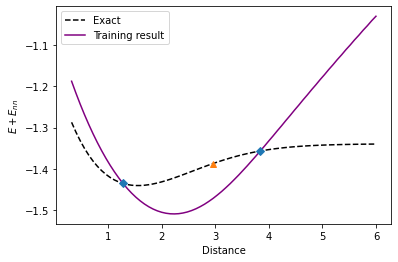

In [6]:
print("------------------------")
print("Best hyperparameters:")
for k, v in best_result.items():
    if k != 'params' and k != 'loss_record':
        print(k,':',v)


params = best_result['params']
result_energies = predict(params, densities)

#Nuclear-nuclear repulsion energy, from the 1D exponential interaction
nuclear_energy = utils.get_nuclear_interaction_energy_batch(
    data.locations,
    data.nuclear_charges,
    interaction_fn=utils.exponential_coulomb)

plt.plot(data.distances, nuclear_energy+total_energies, linestyle='dashed', color='black', label='Exact')
plt.plot(data.distances, nuclear_energy+result_energies, color='purple', label='Training result')
plt.plot(data.distances[train_mask], (nuclear_energy+total_energies)[train_mask], marker='D', linestyle='None')
plt.plot(data.distances[validation_mask], (nuclear_energy+total_energies)[validation_mask], marker='^', linestyle='None')

plt.xlabel('Distance')
plt.ylabel('$E + E_{nn}$')
plt.legend()

plt.show()

Plot checkpoints

5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

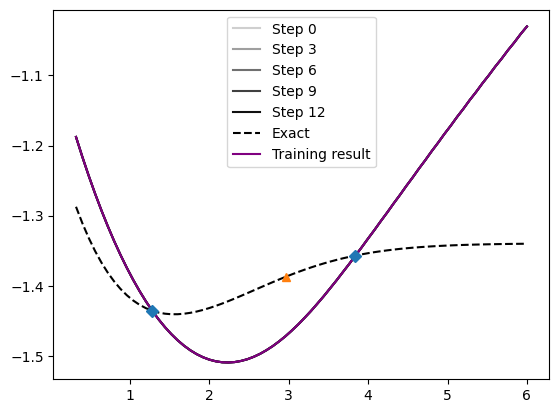

In [8]:
result = best_result #train_and_return(1.0, jnp.array([ 310675292, 2884451463], np.uint32))
loss_record = result['loss_record']
print(len(loss_record))

for param, step in loss_record[::]:
  shade = 1 - (step+3) / (result['num_steps']+3)
  plt.plot(data.distances, nuclear_energy+predict(param, data.densities), color=(shade, shade, shade), label=f'Step {step}')

plt.plot(data.distances, nuclear_energy+total_energies, linestyle='dashed', color='black', label='Exact')
plt.plot(data.distances, nuclear_energy+predict(result['params'], data.densities), color='purple', label='Training result')
plt.plot(data.distances[train_mask], (nuclear_energy+total_energies)[train_mask], marker='D', linestyle='None')
plt.plot(data.distances[validation_mask], (nuclear_energy+total_energies)[validation_mask], marker='^', linestyle='None')

plt.legend()

plt.rcParams.update(plt.rcParamsDefault)

from google.colab import files
filename = "silu_original.png"
plt.savefig(filename)
files.download(filename) 

plt.show()